In [1]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




# 실험 설계
**오늘의 주제 : Seq2seq 기반 번역기**
1. 데이터 전처리 
2. 모델 설계 
3. 훈련 하기
4. 한영 번역기 적용

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm    # tqdm
import random
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


In [4]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [5]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


# 데이터 전처리
## 데이터 정제하기

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

Decoder를 위해 문장의 시작과 끝에 `<start>`와 `<end>`를 붙여준다.

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [8]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


## 토큰화

In [9]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    
    #padding을 pre로 바꿈
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [10]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


# 모델 설계

1. 설계 목표 : GRU를 사용하는 Encoder-Decoder
Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, (2) Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다. Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.
Attention은 Bahdanau.

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [14]:
enc_tensor[0:100]

array([[   0,    0,    0,    0,    0,    0,    0,   34,    1],
       [   0,    0,    0,    0,    0,    0,    0,   34,    1],
       [   0,    0,    0,    0,    0,    0,    0,   34,    1],
       [   0,    0,    0,    0,    0,    0,    0,   34,    1],
       [   0,    0,    0,    0,    0,    0,    0,  677,    1],
       [   0,    0,    0,    0,    0,    0,    0,  311,   35],
       [   0,    0,    0,    0,    0,    0,    0,  311,    1],
       [   0,    0,    0,    0,    0,    0,    0,   58,    5],
       [   0,    0,    0,    0,    0,    0,    0,  433,   35],
       [   0,    0,    0,    0,    0,    0,    0,  433,   35],
       [   0,    0,    0,    0,    0,    0,    0,  433,   35],
       [   0,    0,    0,    0,    0,    0,    0,   71,   35],
       [   0,    0,    0,    0,    0,    0,    0,   71,   35],
       [   0,    0,    0,    0,    0,    0,    0,   71,   35],
       [   0,    0,    0,    0,    0,    0,    0,  842,   35],
       [   0,    0,    0,    0,    0,    0,    0,  842,

In [15]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# 훈련 준비
## Optimizer & Loss

In [42]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

`SparseCategoricalCrossentropy()` 에 대해서 : 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구함. 
ex ) `[ 0.1, 0.2, 0.7 ]`이 입력으로 들어왔을 때, 이를 2와 비교
`from_logits`는 입력값이 확률 분포 함수를 거친 결과값이냐는 물음. 우리는 softmax로 이미 처리를 해줬기 때문에 True로 넣는다. 
**중요 : padding 처리를 한 부분이 padding임을 알려야 한다. 반복해서 가장 많이 등장할 값이기 때문이다. 찍어서 맞출 확률이 높아진다.**
ex) equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리

In [43]:
# GPU를 사용해서 학습하도록 하는 데코레이션. 첫 학습 단계에는 데코레이션이 붙은 함수를 GPU에 등록하도록 하기 때문에 속도가 살짝 느릴 것이다. 
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    # GradientTape에 학습 과정 동안 발생한 모든 연산들을 기록한다. 
    # 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

해당 함수를 이해하기 위한 reference 문서는 다음과 같다. 
- @tf.function : https://www.tensorflow.org/guide/function?hl=ko
- tf.GradientTape() : https://www.tensorflow.org/guide/autodiff?hl=ko
그리고 해당 함수의 학습 과정은 다음과 같다. 
1. 컨텍스트 벡터 생성 : Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. Decoder 입력 준비 : Decoder에 입력으로 전달할 <start> 토큰 문장 생성
3. Decoder Hidden State 초기화 : t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. `h_dec = enc_out[:, -1]`
4. <start> 문장과 enc_out(encoder의 출력 전부), Hidden State를 기반으로 다음 단어(t=1)를 예측. `pred`
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 1-5 반복

In [18]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  1:   5%|▍         | 18/375 [00:16<05:36,  1.06it/s, Loss 2.4398] 


KeyboardInterrupt: 

In [56]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


#translate("Can I have some coffee?", encoder, decoder)

In [ ]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

In [19]:
!ls ~/aiffel/s2s_translation/korean-english-park.train /

/:
bin    dev   initrd.img      lib64	 mnt   root  snap      sys  var
boot   etc   initrd.img.old  lost+found  opt   run   srv       tmp  vmlinuz
cdrom  home  lib	     media	 proc  sbin  swapfile  usr  vmlinuz.old

/home/aiffel-dj15/aiffel/s2s_translation/korean-english-park.train:
korean-english-park.train.en  korean-english-park.train.ko


In [20]:
path_to_file = "/home/aiffel-dj15/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.ko"
with open(path_to_file, "r") as f:
    ko_raw = f.read().splitlines()
path_to_file = "/home/aiffel-dj15/aiffel/s2s_translation/korean-english-park.test/korean-english-park.test.ko"
with open(path_to_file, "r") as f:
    ko_raw2 = f.read().splitlines()
ko_raw += ko_raw2

In [21]:
path_to_file = "/home/aiffel-dj15/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.en"
with open(path_to_file, "r") as f:
    en_raw = f.read().splitlines()
path_to_file = "/home/aiffel-dj15/aiffel/s2s_translation/korean-english-park.test/korean-english-park.test.en"
with open(path_to_file, "r") as f:
    en_raw2 = f.read().splitlines()
en_raw += en_raw2

In [22]:
ko_raw[:100]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
 '이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.',
 '국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.',
 '이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.',
 '"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."',
 '연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.',
 '약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌

In [23]:
en_raw[:100]

['Much of personal computing is about "can you top this?"',
 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "Like all optical mice, But it also doesn't need a desk.",
 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.",
 "After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.",
 'Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help staying alert for longer

In [24]:
ko_dup_remove = set(ko_raw)
en_dup_remove = set(en_raw)
print(len(ko_raw), len(ko_dup_remove))
print(len(en_raw), len(en_dup_remove))

96123 79569
96123 77534


중복 제거 후 쌍이 맞지 않는 문제가 발생했다. 그래서 이를 다시 맞추기 위해서 for 문으로 중복을 처리하겠다. 

In [25]:
ko_dup_remove = []
en_dup_remove = []
for i in range(len(en_raw)) :
    if en_raw[i] in en_dup_remove :
        continue
    else :
        ko_dup_remove.append(ko_raw[i])
        en_dup_remove.append(en_raw[i])
print(len(ko_raw), len(ko_dup_remove))
print(len(en_raw), len(en_dup_remove))

96123 77534
96123 77534


In [26]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

그리고 형태소 기반 mecab 한국어 토큰화와 keras 기반 영어 토큰화, 케라스 토크나이저와 텐서 생성까지 한꺼번에 처리하는 함수를 정의한다. 

In [29]:
from konlpy.tag import Mecab
def make_tokenizer(ko_corpus, en_corpus, num_vocab=100000, max_len=40) :
    ko_corpus_after_pre = [preprocess_sentence(x) for x in ko_corpus]
    en_corpus_after_pre = [preprocess_sentence(x, True, True) for x in en_corpus]
     
    mecab = Mecab()
    ko_corpus_after_mecab = []
    
    for i in ko_corpus_after_pre :
        res = mecab.morphs(i)
        res = " ".join(res)
        ko_corpus_after_mecab.append(res)
    
    
    ko_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                          num_words=num_vocab)
    ko_tokenizer.fit_on_texts(ko_corpus_after_mecab)
    ko_tensor = ko_tokenizer.texts_to_sequences(ko_corpus_after_mecab)
    
    
    en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                          num_words=num_vocab)
    en_tokenizer.fit_on_texts(en_corpus_after_pre)
    en_tensor = en_tokenizer.texts_to_sequences(en_corpus_after_pre)
    
    
    ko_tensor_cut = []
    en_tensor_cut = []
    
    for ko, en in zip(ko_tensor, en_tensor) :
        if len(ko) <= 40 and len(en) <= 40 :
            ko_tensor_cut.append(ko)
            en_tensor_cut.append(en)
            
    ko_tensor_cut = tf.keras.preprocessing.sequence.pad_sequences(ko_tensor_cut, padding='pre')     
    en_tensor_cut = tf.keras.preprocessing.sequence.pad_sequences(en_tensor_cut, padding='pre')

    return ko_tensor_cut, en_tensor_cut, ko_tokenizer, en_tokenizer 

In [30]:
en_tensor, dec_tensor, en_tokenizer, dec_tokenizer = make_tokenizer(ko_dup_remove, en_dup_remove)

In [31]:
print("Korean Vocab Size:", len(en_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 51703
English Vocab Size: 46868


In [32]:
print(en_tensor.shape)
print(dec_tensor.shape)

(59589, 40)
(59589, 40)


In [33]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(en_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 46869)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [34]:
print(encoder.summary())
print(decoder.summary())

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  6618112   
_________________________________________________________________
gru_2 (GRU)                  multiple                  99072     
Total params: 6,717,184
Trainable params: 6,717,184
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  5999232   
_________________________________________________________________
gru_3 (GRU)                  multiple                  148224    
_________________________________________________________________
dense_4 (Dense)              multiple                  6046101   
_______________________

In [ ]:
dec_tensor[0:5]

In [53]:
def get_train_function() :
    @tf.function
    def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
        bsz = src.shape[0]
        loss = 0

        # GradientTape에 학습 과정 동안 발생한 모든 연산들을 기록한다. 
        # 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용
        with tf.GradientTape() as tape:
            enc_out = encoder(src)
            h_dec = enc_out[:, -1]

            dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

            for t in range(1, tgt.shape[1]):
                pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

                loss += loss_function(tgt[:, t], pred)
                dec_src = tf.expand_dims(tgt[:, t], 1)

        batch_loss = (loss / int(tgt.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss
    return train_step

In [39]:
#just for test
def train_step_CPU(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    # GradientTape에 학습 과정 동안 발생한 모든 연산들을 기록한다. 
    # 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [50]:
def take_train(enc_train, dec_train, encoder, decoder, optimizer, dec_tokenizer,EPOCHS=50 ) :
    for epoch in range(EPOCHS):
        total_loss = 0
        log = []
        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)    # tqdm

        for (batch, idx) in enumerate(t):
            batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                    dec_train[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    optimizer,
                                    dec_tokenizer)

            total_loss += batch_loss
            log.append(total_loss.numpy())
            t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
    return log

In [52]:
optimizer = tf.keras.optimizers.Adam()
result = take_train(en_tensor, dec_tensor, encoder, decoder, optimizer, dec_tokenizer)

  0%|          | 0/932 [00:13<?, ?it/s]


ValueError: in user code:

    <ipython-input-43-2bd4c2d4f232>:25 train_step  *
        optimizer.apply_gradients(zip(gradients, variables))
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients  **
        self._create_all_weights(var_list)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:781 _create_all_weights
        _ = self.iterations
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:926 iterations
        aggregation=tf_variables.VariableAggregation.ONLY_FIRST_REPLICA)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1132 add_weight
        aggregation=aggregation)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py:810 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:221 _variable_v1_call
        shape=shape)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:731 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [54]:
from tqdm import tqdm    # tqdm
import random
import os
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

EPOCHS = 50

log = []

optimizer = tf.keras.optimizers.Adam()
train_step_2 = get_train_function()

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, en_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step_2(en_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        log.append(total_loss.numpy())
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 50: 100%|██████████| 932/932 [02:15<00:00,  6.86it/s, Loss 1.1383]


**BIG ISSUE ON THIS NODE**
https://github.com/tensorflow/tensorflow/issues/27120
do not use the @tf.function decoration right after declation

In [57]:
sample_sen = [
    "대통령 선거가 시작되었다",
    "산불이 크게 났다",
    "인터넷 속도가 빨라졌다",
    "버락 오마바가 대통령 선거에서 우승했다",
    "미국이 해당 지역에 파병을 결정했다"
]

In [60]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], en_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = en_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=en_tensor.shape[-1],
                                                           padding='pre')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 대통령 선거가 시작되었다
Predicted translation: korean politics <end> 


/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj15/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


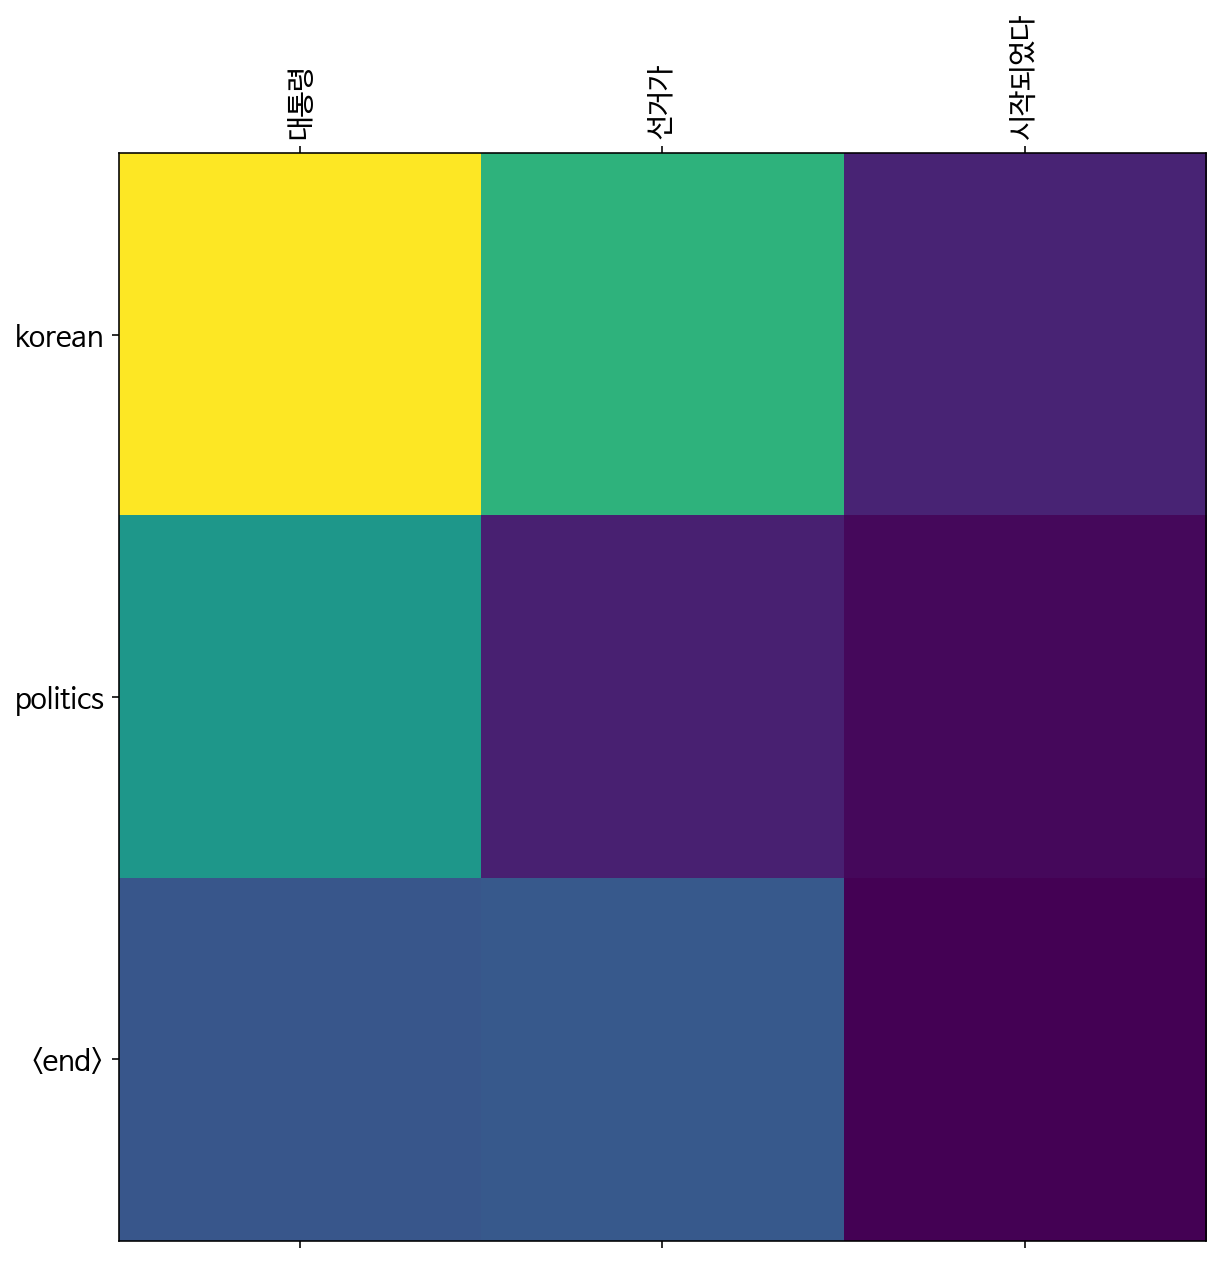

Input: 산불이 크게 났다
Predicted translation: in <end> 


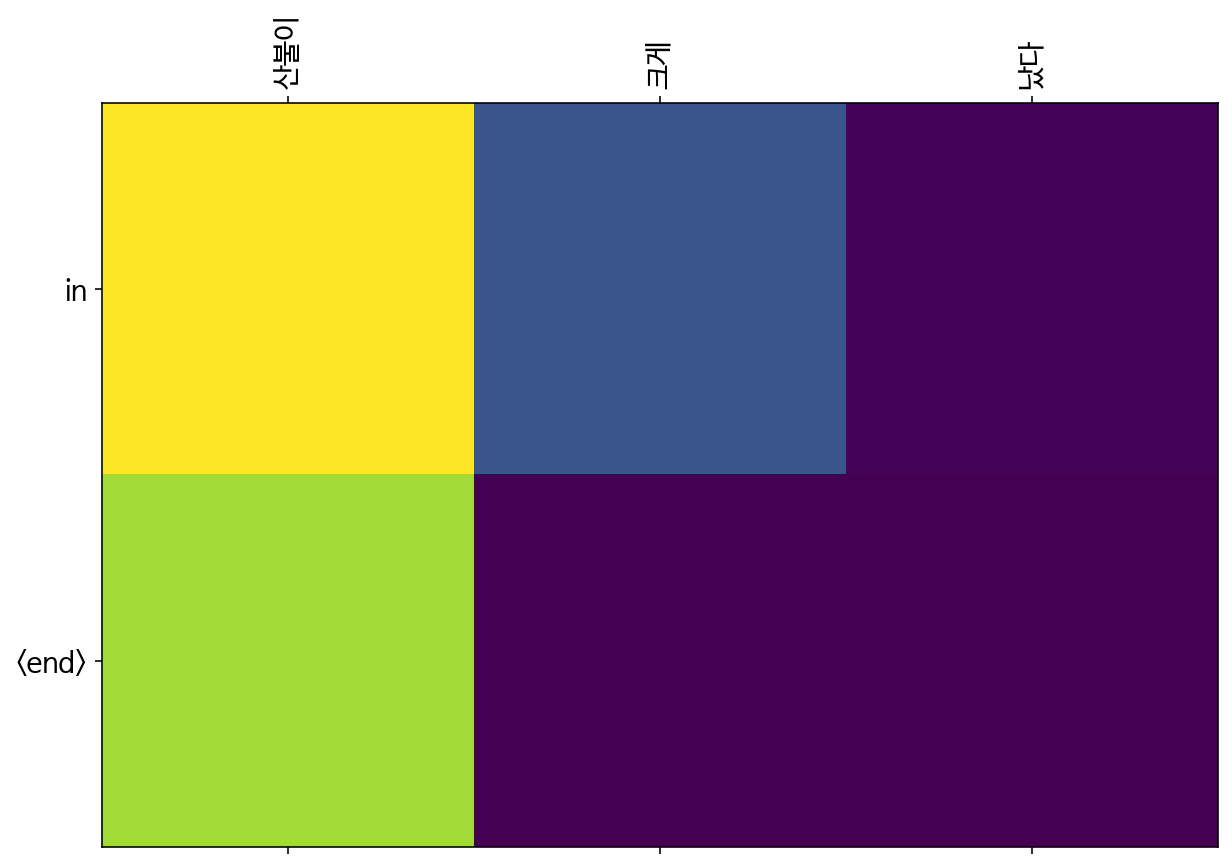

Input: 인터넷 속도가 빨라졌다
Predicted translation: in korea <end> 


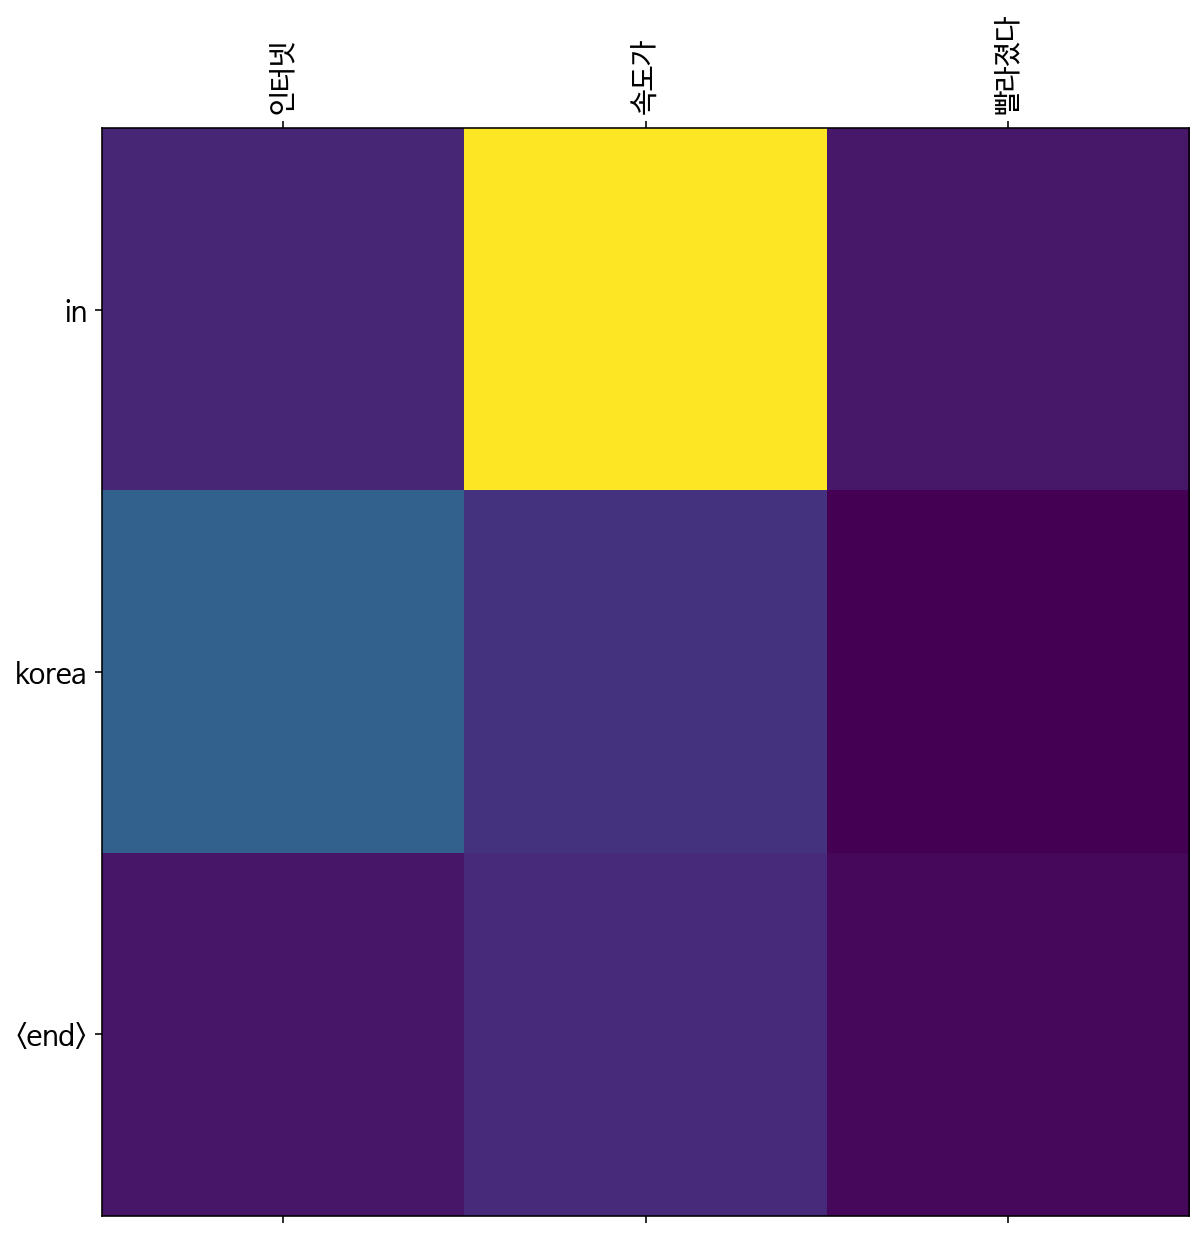

Input: 버락 오마바가 대통령 선거에서 우승했다
Predicted translation: presidential candidate <end> 


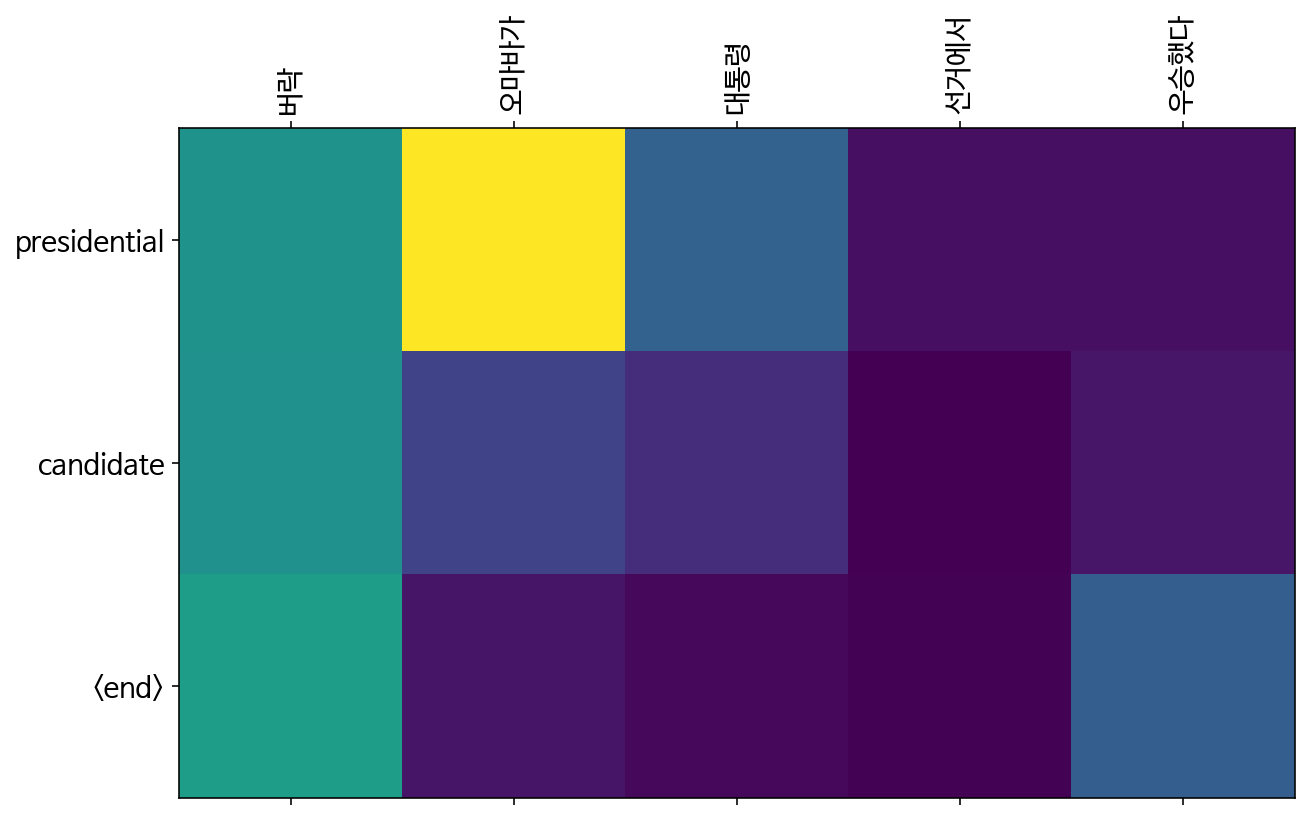

Input: 미국이 해당 지역에 파병을 결정했다
Predicted translation: in the meantime , dangerous ? <end> 


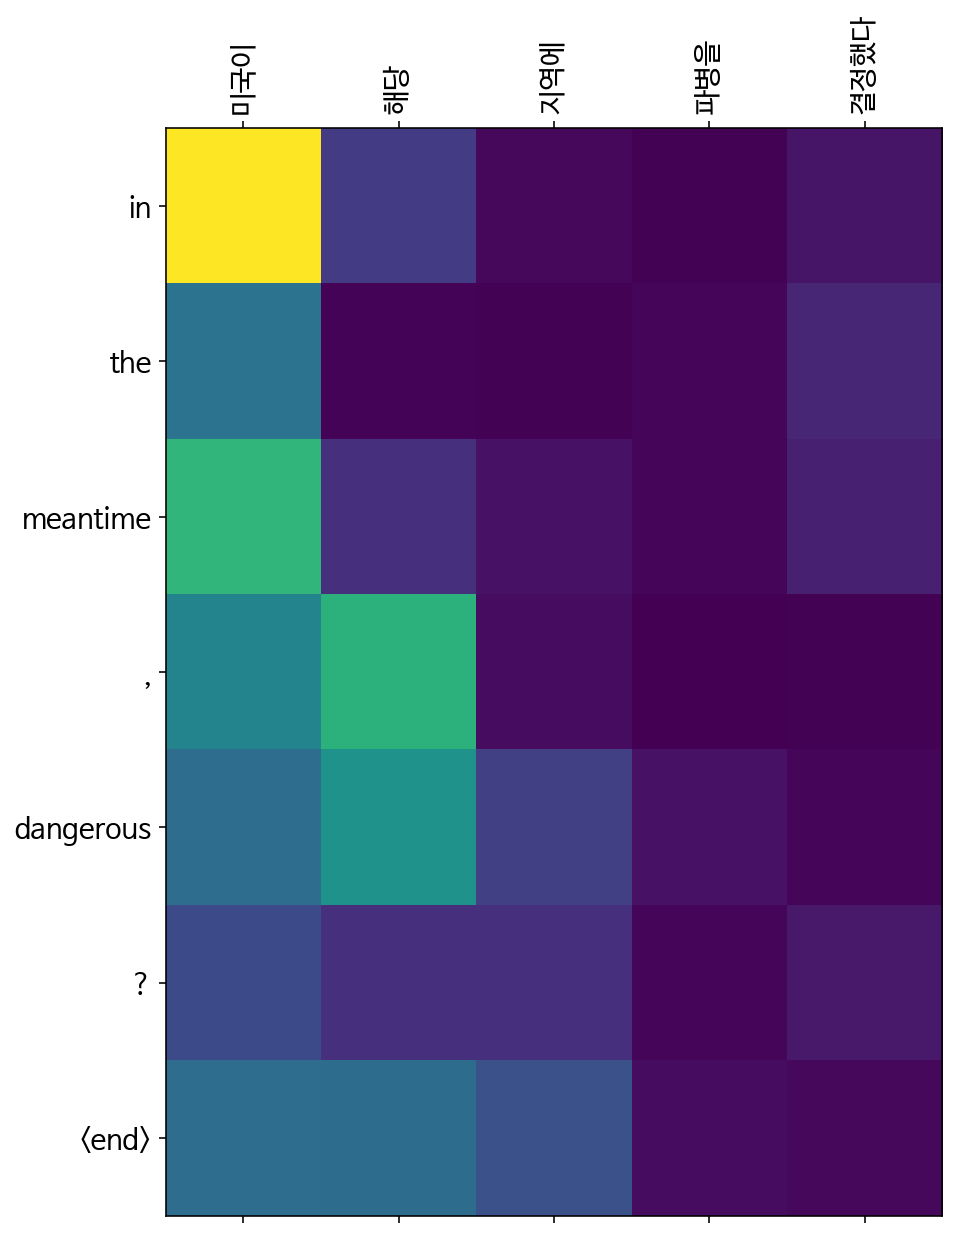

In [61]:
for i in sample_sen :
    translate(i, encoder, decoder)

# 결과
일단 전처리를 최소한으로 하고 모델을 구축했는데, 이 과정에서 한국어는 형태소, 미국은 단순히 공백 단위의 토큰화를 해서
'미국' 을 아예 형태소로 분리해서 넣는 사태가 발생했다. 결과에 보면 '미국이 해당 지역에 파병을 결정했다.' 의 결과가 'in the meantime, dangerous?'라고 나온거 보면 미와 국을 따로 분리해서 모델에 넣은 것으로 추측한다. 
다만 학습의 loss는 3에서 1.1대로 지속적으로 감소함을 볼 수 있다. 